## eBOSC Tutorial 

The code used in this script is modified from https://github.com/jkosciessa/eBOSC_py 

This method takes in a 1-dimensional time series of preprocessed electrophysiological data. A dataframe containing the characteristics (timing, frequency, power, etc.) of each detected burst is returned. 

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from ebosc.helpers import get_project_root
from ebosc.eBOSC_wrapper import eBOSC_wrapper
import scipy.io as io
from papto_functions import * 

In [2]:
# Read in one-dimensional time series (preprocessed)
data_dir =  '/export03/data/lindseyp/burst_methods_review/' 
raw_data = np.loadtxt(data_dir + '1d_array.txt')

# Configure data to pandas dataframe format expected by eBOSC algorithm 
Fs = 1000
region = 'SomMotA_4 R'
times = np.arange(0,len(raw_data))/ Fs
data = pd.DataFrame({'time':times, 'condition':[1]*len(times), 'epoch':[0]*len(times),region:raw_data})

data.head(10)

,time,condition,epoch,SomMotA_4 R
0,0.000,1,0,0.054190
1,0.001,1,0,0.308582
2,0.002,1,0,0.561679
3,0.003,1,0,0.686162
4,0.004,1,0,0.718723
5,0.005,1,0,0.676180
6,0.006,1,0,0.625884
7,0.007,1,0,0.623270
8,0.008,1,0,0.723335
9,0.009,1,0,0.945915


### 1. Set Model Parameters 

The eBOSC method takes in a dictionary containing information about the parameters and settings of the model. 

Important parameters to note include the 'F' parameter which specifies the frequency sample of interest, 'fsample' which must be set to the sampling rate of your data, and the threshold parameters which can be modified to influence the sensitivity of the model.

More information on these parameters can found at https://github.com/jkosciessa/eBOSC_py 

In [3]:
# eBOSC parameters 
cfg_eBOSC = dict()
cfg_eBOSC['F'] = np.arange(1,30,1)          # frequency sampling (we only want 15-30 Hz but in order to create PSD we need low frequencies)
cfg_eBOSC['wavenumber'] = 6                 # wavelet parameter (time-frequency tradeoff)
cfg_eBOSC['fsample'] = 1000                 # current sampling frequency of MEG data
cfg_eBOSC['pad.tfr_s'] = 1                  # padding following wavelet transform to avoid edge artifacts in seconds (bi-lateral)
cfg_eBOSC['pad.detection_s'] = .5           # padding following rhythm detection in seconds (bi-lateral); 'shoulder' for BOSC eBOSC.detected matrix to account for duration threshold
cfg_eBOSC['pad.background_s'] = 1           # padding of segments for BG (only avoiding edge artifacts)

# Threshold settings 
cfg_eBOSC['threshold.excludePeak'] = np.array([[8,15]])                       # lower and upper bound of frequencies to be excluded during background fit (Hz) 
cfg_eBOSC['threshold.duration'] = np.array([2]*len(cfg_eBOSC['F'])).reshape(1,len(cfg_eBOSC['F'])) # vector of duration thresholds at each frequency (number of cycles, shape (1,number of freqs))
cfg_eBOSC['threshold.percentile'] = .95                                       # percentile of background fit for power threshold

# Rhythmic episode post-processing
cfg_eBOSC['postproc.use'] = 'yes'           # Post-processing of rhythmic eBOSC.episodes, i.e., wavelet 'deconvolution' (default = 'no')
cfg_eBOSC['postproc.method'] = 'FWHM'       # Deconvolution method (default = 'MaxBias', FWHM: 'FWHM')
cfg_eBOSC['postproc.edgeOnly'] = 'yes'      # Deconvolution only at on- and offsets of eBOSC.episodes? (default = 'yes')
cfg_eBOSC['postproc.effSignal'] = 'PT'      # Power deconvolution on whole signal or signal above power threshold? (default = 'PT')

# General processing settings
cfg_eBOSC['channel'] = [region]          # select channel of interest
cfg_eBOSC['trial'] = []                  # select trials (default: all, indicate in natural trial number (not zero-starting))
cfg_eBOSC['trial_background'] = []       # select trials for background (default: all, indicate in natural trial number (not zero-starting))

### 2. Run eBOSC Detection

The eBOSC method has a fully-integrated python package and therefore does not require manual processing steps or locally-stored utility functions. Calling the eBOSC_wrapper function as below will perform all necessary processing steps: calculating the TFR, fitting the aperiodic component and applying thresholds to detect bursts in the data. 

The function returns an eBOSC object containing information about the various outputs of the model. eBOSC['episodes'] provides information about the specific characteristics of the detected bursts.

For more information on the specific processing steps completed by this function see: https://github.com/jkosciessa/eBOSC_py 

In [4]:
# Run eBOSC
[eBOSC, cfg] = eBOSC_wrapper(cfg_eBOSC, data)

Channel: SomMotA_4 R; Nr. 1/1
Removing frequency peaks from the background
Trial Nr. 1/1
Creating sparse detected matrix ...
Applying FWHM post-processing ...
Removing padding from detected episodes


In [5]:
# Find episodes with a beta (15-30 Hz) Frequency
burst_df = pd.DataFrame(eBOSC['episodes'])

peak_freq_list = []
for i in range(0,len(burst_df)):
    peak_power_ind = np.argmax(burst_df['Power'].tolist()[i])
    peak_freq = (burst_df['Frequency'].tolist()[i])[peak_power_ind]
    peak_freq_list.append(peak_freq)
burst_df['Peak Frequency'] = peak_freq_list
burst_df['Event Duration'] = burst_df['DurationS']
burst_df['Peak Time'] = burst_df['Onset']+(burst_df['Event Duration']/2)

burst_df = burst_df[burst_df['Peak Frequency']>=15]
burst_df = burst_df[burst_df['Peak Frequency']<=30]

burst_df.head(5)

,RowID,ColID,Frequency,FrequencyMean,Power,PowerMean,DurationS,DurationC,Trial,Channel,Onset,Offset,SNR,SNRMean,Peak Frequency,Event Duration,Peak Time
3,"[16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 1...","[1796, 2325]","[17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 17.0, 18....",18.315094,"[46458.848, 47068.863, 47672.168, 48267.86, 48...",315815.562500,0.529,9.688685,1,SomMotA_4 R,3.298,3.827,"[1.3112693239478854, 1.3112693239478854, 1.311...",9.281573,18.0,0.529,3.5625
4,"[28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 28, 2...","[2276, 2615]","[29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29.0, 29....",27.620588,"[64991.598, 65014.863, 64933.2, 64753.9, 64485...",266743.406250,0.339,9.363379,1,SomMotA_4 R,3.778,4.117,"[2.5320619088759293, 2.5320619088759293, 2.532...",10.087878,25.0,0.339,3.9475
6,"[20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 2...","[2694, 2816]","[21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21.0, 21....",22.341463,"[139868.03, 136309.27, 132855.34, 129507.47, 1...",73149.289062,0.122,2.725658,1,SomMotA_4 R,4.196,4.318,"[4.484667452532838, 4.484667452532838, 4.48466...",2.465538,21.0,0.122,4.2570
7,"[23, 23, 23, 23, 23, 23, 23, 24, 24, 24, 24, 2...","[2998, 3247]","[24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 24.0, 25....",22.068001,"[38917.684, 39692.215, 40455.777, 41207.086, 4...",101961.804688,0.249,5.494932,1,SomMotA_4 R,4.500,4.749,"[1.3863096784031417, 1.3863096784031417, 1.386...",3.372223,18.0,0.249,4.6245
9,"[18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 1...","[3269, 3378]","[19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19.0, 19....",20.100000,"[181451.17, 179886.8, 178341.89, 176820.45, 17...",243134.406250,0.109,2.190900,1,SomMotA_4 R,4.771,4.880,"[5.47693637374805, 5.47693637374805, 5.4769363...",7.590841,21.0,0.109,4.8255


In [6]:
# Record burst rate 
burstRate = burst_df.shape[0]/(raw_data.shape[0]/Fs)
print("Burst Rate:")
print(burstRate)

Burst Rate:
0.9558303886925795


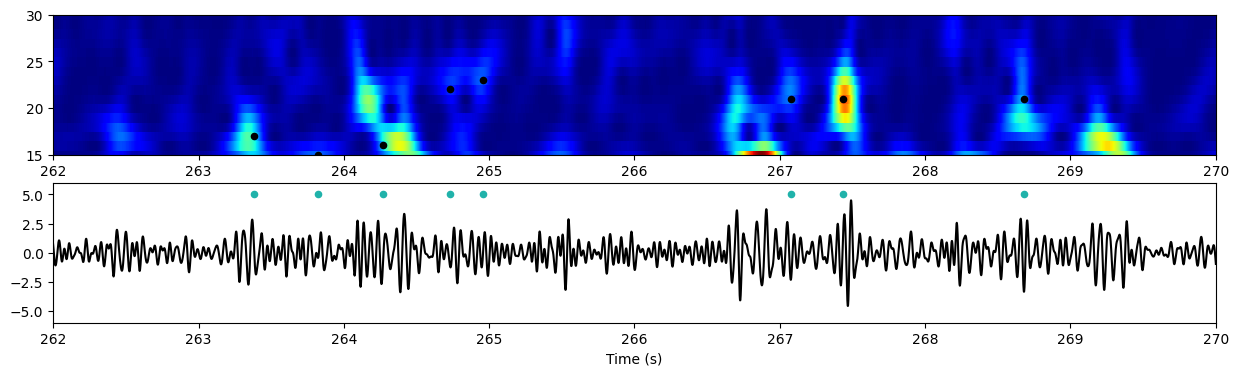

In [16]:
# Make a TFR for data
# TFR params #
Fs = 1000.0      # Sampling frequency (Hz)
fmin = 15.0         # Hertz (integer)
fmax = 30.0        # Hertz (integer)
fstep = 1.0         # Hertz (integer)
fVec = np.arange(fmin, fmax+1, fstep)
chan_data = np.reshape(raw_data, (raw_data.shape[0],1)) #reshapes because function expects epochs 
TFR, tVec = TFR_via_morlet_wavelet(chan_data, fVec, Fs)

# Plot showing where the bursts are identified in the TFR along with a visualization of the corresponding times in the raw signal 
fig, axs = plt.subplots(2,1, figsize=(15,4))
scale_val = 20

# Plot TFR with overlaid burst times/frequencies 
TFR_crop = np.asarray(TFR)[:,:,262000:270000]
im = axs[0].pcolor(tVec[262000:270000], fVec, np.squeeze(TFR_crop), cmap='jet')
axs[0].scatter(burst_df['Peak Time'], burst_df['Peak Frequency'] ,c='black',s=scale_val,zorder=1)
axs[0].set_xlim(262,270)
axs[0].set_ylim(15,30)

# Plot indication of burst peak times with respect to raw (bandpassed) time series
beta_filt_dat = mne.filter.filter_data(np.squeeze(chan_data), Fs, l_freq=15.0, h_freq=30.0,verbose=False)
times = np.arange(0,chan_data.shape[0])/Fs
axs[1].plot(times,beta_filt_dat,zorder=0,c='black')
axs[1].scatter(burst_df['Peak Time'], [5]*len(burst_df['Peak Time']) ,c='lightseagreen',s=scale_val,zorder=1)
axs[1].set_ylim(-6,6)
axs[1].set_xlim(262,270)
plt.xlabel('Time (s)')

plt.show()